# **Udacity: Intro to TensorFlow for Deep Learning**
### **Lesson 9 NLP Exercise: Tokenization and Embeddings**



# **Training a basic sentiment analysis model on an NLP dataset**

**Sentiment Analysis with Movie Review dataset**

With all the steps and techniques that we have seen above we should now have the tools we need to train an NLP model to perform basic sentiment analysis

## **Import required packages**


In [1]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

print(tf.__version__)

2.8.2


## **Get the data**

Using the movie reviews dataset

In [2]:
# import tensorflow datasets
import tensorflow_datasets as tfds

print(tfds.__version__)

4.0.1


Link to tfds loads function [tfds.loads](https://www.tensorflow.org/datasets/api_docs/python/tfds/load)



Link to movie_rationales documentation [movie_rationales](https://www.tensorflow.org/datasets/catalog/movie_rationales)

In [3]:
# load the movie reviews dataset including the training, test and validation set
(movie_review_train, movie_review_test, movie_review_validation), info = tfds.load(name='movie_rationales',
                                                                                   split=['train', 'test', 'validation'],
                                                                                   shuffle_files=True,
                                                                                   as_supervised=False,
                                                                                   with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/movie_rationales/0.1.0.incompleteP3XAMR/movie_rationales-train.tfrecord


  0%|          | 0/1600 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/movie_rationales/0.1.0.incompleteP3XAMR/movie_rationales-validation.tfrecord


  0%|          | 0/200 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/movie_rationales/0.1.0.incompleteP3XAMR/movie_rationales-test.tfrecord


  0%|          | 0/199 [00:00<?, ? examples/s]

Dataset movie_rationales downloaded and prepared to /root/tensorflow_datasets/movie_rationales/0.1.0. Subsequent calls will reuse this data.


In [4]:
# display the metadata for the dataset
info

tfds.core.DatasetInfo(
    name='movie_rationales',
    version=0.1.0,
    description='The movie rationale dataset contains human annotated rationales for movie
reviews.',
    homepage='http://www.cs.jhu.edu/~ozaidan/rationales/',
    features=FeaturesDict({
        'evidences': Sequence(Text(shape=(), dtype=tf.string)),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'review': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=1999,
    splits={
        'test': 199,
        'train': 1600,
        'validation': 200,
    },
    supervised_keys=None,
    citation="""@unpublished{eraser2019,
        title = {ERASER: A Benchmark to Evaluate Rationalized NLP Models},
        author = {Jay DeYoung and Sarthak Jain and Nazneen Fatema Rajani and Eric Lehman and Caiming Xiong and Richard Socher and Byron C. Wallace}
    }
    @InProceedings{zaidan-eisner-piatko-2008:nips,
      author    =  {Omar F. Zaidan  and  Jason Eisner  and  Christine Piatko},
 

## **Explore and Prepare the data**

Pipeline for preparing text data as input to an NLP model
- Tokenize
- Convert sentences into sequences
- Apply padding and truncating

In [5]:
# view an instance from the movie_review training dataset
movie_review_train.take(1)

<TakeDataset element_spec={'evidences': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'review': TensorSpec(shape=(), dtype=tf.string, name=None)}>

looking at the doc, as we set the as_supervised function to be False, the value in each instance should be a dictionary of features and looking at the docs for the movie rational, we have evidence, label and review as features

In [6]:
# display the number of examples we have in the training, validation and test set
print("Number of training set: {}".format(len(movie_review_train)))
print("Number of test set: {}".format(len(movie_review_test)))
print("Number of validation set: {}".format(len(movie_review_validation)))


Number of training set: 1600
Number of test set: 199
Number of validation set: 200


This matches up with what is stated in the doc

In [7]:
# display two samples from the training set
for data in movie_review_train.take(2):
  print(data['evidences'])
  print(data['label'])
  print(data['review'])
  print('\n')

tf.Tensor(
[b'stale actioners' b'unworthy of the most gullible audience member'
 b'everything begins going downhill . . . quickly .' b'for all its faults'
 b'ludicrous' b'painfully familiar' b'simply oozes sliminess'
 b"for some reason that 's never explained in the film"
 b'but the biggest problem with mercury rising is the screenplay'
 b"was n't well thought out at all" b'it is every bit as stale'
 b'are just overplaying to type'
 b"by the gruesomely bad finale they 're a veritable flood"], shape=(13,), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(b'bruce willis needs to stay away from straightforward action pictures .\nmercury rising adds to a growing list ( including such stinkers as the jackal , last man standing , striking distance and the last boy scout ) of stale actioners\nhe has headlined .\nand though mercury rising tries to spice things up by throwing an autistic kid in the mix , it is every bit as stale .\nart jeffries ( bruce willis ) is your typical tormen

Something i would like to remove are the \n  \' and  b'. I think we should be able to remove it with the Tokenizer, it's worth a try.

better solution: https://stackoverflow.com/questions/37016946/remove-b-character-do-in-front-of-a-string-literal-in-python-3

In [8]:
# define a function to extract the review and labels from the dataset
def extract_review_and_label(Dataset):
  """Function written to extract review and label from movie rationales dataset."""
  review = []
  labels = []

  length = len(Dataset)
  for data in Dataset.take(length):
    review.append(data['review'].numpy().decode("utf-8"))
    labels.append(data['label'].numpy())
  
  return review, labels

reviews, labels = extract_review_and_label(movie_review_train)

In [9]:
# Display an instances from the returned reviews and labels
for review, label in zip(reviews, labels):
  print("Review: {}".format(review))
  print("Label: {}".format(label))
  print("\n")
  break

Review: bruce willis needs to stay away from straightforward action pictures .
mercury rising adds to a growing list ( including such stinkers as the jackal , last man standing , striking distance and the last boy scout ) of stale actioners
he has headlined .
and though mercury rising tries to spice things up by throwing an autistic kid in the mix , it is every bit as stale .
art jeffries ( bruce willis ) is your typical tormented fbi agent .
you know the type , haunted by his job , yet so good at what he does that even physically assaulting another agent merely gets him a slap on the wrist .
enter simon ( miko hughes ) , an autistic boy , who , like rain man and all other autistic people , is a savant .
he can merely gaze at a super - encrypted message , and , while little computer beeps go off in his head , he can understand what it says .
naturally , this talent has brought him to the attention of the federal government .
lt .
col .
nicholas kudrow ( alec baldwin ) ,
an nsa official

In [10]:
# Prepare the training, test and validation reviews dataset
train_features, train_labels = extract_review_and_label(movie_review_train)
test_features, test_labels = extract_review_and_label(movie_review_test)
validation_features, validation_labels = extract_review_and_label(movie_review_validation)


**Tokenize the training set**

In [11]:
# define the tokenizer and fit it to the training reviews 
# use the 5000 most common words in the reivews dataset
movie_review_tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
movie_review_tokenizer.fit_on_texts(train_features)


In [12]:
# view the word index of the trained tokenizer
word_index = movie_review_tokenizer.word_index
print(word_index)


{'<OOV>': 1, 'the': 2, 'a': 3, 'and': 4, 'of': 5, 'to': 6, 'is': 7, 'in': 8, "'s": 9, 'it': 10, 'that': 11, 'as': 12, 'with': 13, 'for': 14, 'his': 15, 'this': 16, 'film': 17, 'i': 18, 'he': 19, 'but': 20, 'on': 21, 'are': 22, 'by': 23, "n't": 24, 'be': 25, 'one': 26, 'an': 27, 'who': 28, 'movie': 29, 'not': 30, 'you': 31, 'was': 32, 'have': 33, 'at': 34, 'from': 35, 'has': 36, 'they': 37, 'her': 38, 'all': 39, 'there': 40, 'like': 41, 'so': 42, 'out': 43, 'about': 44, 'up': 45, 'what': 46, 'more': 47, 'when': 48, 'do': 49, 'which': 50, 'or': 51, 'their': 52, 'she': 53, 'some': 54, 'just': 55, 'does': 56, 'if': 57, 'we': 58, 'into': 59, 'him': 60, 'even': 61, 'no': 62, "'": 63, 'only': 64, 'than': 65, 'good': 66, 'time': 67, 'can': 68, 'would': 69, 'most': 70, 'its': 71, 'will': 72, 'story': 73, 'been': 74, 'much': 75, 'also': 76, 'character': 77, 'get': 78, 'other': 79, 'well': 80, 'two': 81, 'very': 82, 'first': 83, 'them': 84, 'characters': 85, 'after': 86, 'see': 87, 'way': 88, 'be

it looks like, there is a wide range of words used in each review, with some of the words having context related to specific reviews, for now i've chosen 5000 as an arbitary cut off point for the size of the word_index. Any higher and the tokenizer would capture more words used specifically for certain reviews

In [13]:
# Covert a review into sequences
one_review = reviews[42]
one_review_sequence = movie_review_tokenizer.texts_to_sequences([one_review])

print("Review: {}".format(one_review))
print("Review sequence: {}".format(one_review_sequence))

Review: *
* * be warned . . .
the following review contains some harsh language
*
* * the blair witch project .
quite possibly the least scariest movie of all time .
if you want to see real terror on the big screen go back and watch any scene with jar jar binks in the phantom menace , because this movie is not scary or even remotely creepy .
my colleague and friend chuck dowling wrote that if less is more , then the blair witch filmmakers must have thought that nothing is more .
and this worked for him .
well , i 'm sorry , but nothing .
. . is nothing ! ! ! ! !
nothing is not more .
it 's nothiiiiiinggggggggggg ! ! ! ! ! ! .
i do not pay 5 dollars to see nothing .
" nothing " is free , available all around the world at a location near you .
i am absolutely in amazement that some people find this movie scary .
i could just discount them and say , " well , i guess they are just pansy
chicken shits who are probably scared of their own shadow .
"
but i have intelligent friends who like th

yikes that is a really long sequence, we might want to consider cutting down the length of the sequence.

How long is a typical review??

In [14]:
length_of_review = []
for review in train_features:
  sequence = movie_review_tokenizer.texts_to_sequences([review])
  length_of_review.append(len(sequence[0]))


# taken from https://www.geeksforgeeks.org/find-average-list-python/
def Average(lst):
    return sum(lst) / len(lst)
  
print(length_of_review)
print(Average(length_of_review))

[667, 1536, 455, 872, 987, 774, 714, 595, 636, 773, 190, 638, 582, 439, 671, 782, 899, 490, 1038, 603, 473, 731, 998, 1067, 632, 444, 771, 775, 771, 620, 892, 701, 423, 486, 654, 249, 324, 559, 433, 1176, 302, 815, 1046, 662, 531, 700, 966, 311, 800, 818, 684, 388, 888, 953, 661, 428, 821, 528, 525, 737, 684, 1852, 681, 332, 591, 857, 1295, 548, 605, 302, 985, 493, 795, 949, 318, 1030, 829, 385, 433, 441, 1394, 290, 758, 614, 447, 598, 472, 688, 812, 806, 824, 512, 667, 707, 569, 454, 529, 546, 814, 705, 648, 387, 807, 662, 434, 705, 613, 247, 896, 879, 821, 573, 487, 508, 305, 826, 520, 1889, 554, 674, 1196, 662, 482, 677, 671, 590, 550, 701, 657, 447, 898, 498, 867, 970, 308, 860, 692, 512, 687, 779, 709, 759, 788, 546, 613, 704, 731, 634, 383, 763, 960, 183, 970, 551, 490, 994, 1062, 886, 1178, 1446, 367, 302, 413, 913, 717, 1192, 519, 491, 628, 668, 301, 344, 809, 544, 855, 801, 697, 546, 571, 580, 673, 508, 495, 541, 224, 1315, 546, 735, 642, 947, 517, 259, 1188, 739, 588, 499, 38

So on average it is triple 6, cautious of this number 😅, lets make each sequence length 700.

**Convert the reviews to sequences**

In [15]:
# create sequences from the entire train_features
train_features_sequences = movie_review_tokenizer.texts_to_sequences(train_features)

# display the 2 sequences from the entire list
for sequence in train_features_sequences[:2]:
  print(sequence)
  print("\n")

[992, 1186, 620, 6, 949, 219, 35, 3331, 125, 1243, 4445, 1616, 1261, 6, 3, 1925, 929, 423, 123, 1, 12, 2, 3432, 178, 111, 2023, 3985, 4127, 4, 2, 178, 409, 1, 5, 3433, 1, 19, 36, 1, 4, 154, 4445, 1616, 391, 6, 1524, 173, 45, 23, 2550, 27, 1, 674, 8, 2, 1681, 10, 7, 149, 266, 12, 3433, 693, 1, 992, 1186, 7, 165, 1011, 1, 1403, 841, 31, 120, 2, 634, 2551, 23, 15, 259, 240, 42, 66, 34, 46, 19, 56, 11, 61, 3839, 1, 128, 841, 851, 170, 60, 3, 1, 21, 2, 1, 1890, 982, 1, 2635, 27, 1, 409, 28, 41, 1959, 111, 4, 39, 79, 1, 105, 7, 3, 1, 19, 68, 851, 1, 34, 3, 1926, 1, 880, 4, 99, 98, 461, 1, 130, 97, 8, 15, 379, 19, 68, 791, 46, 10, 561, 2117, 16, 635, 36, 916, 60, 6, 2, 590, 5, 2, 4446, 988, 1, 4128, 3160, 3434, 3161, 1700, 27, 1, 3524, 1, 107, 13, 337, 36, 943, 2707, 67, 4, 275, 1, 2, 4285, 1, 4616, 4445, 145, 48, 81, 5, 15, 1, 537, 1, 4, 1, 1, 3728, 1, 3, 4445, 1, 880, 8, 3, 4790, 2492, 12, 3, 357, 1990, 5, 71, 1, 982, 1, 2, 4616, 2117, 16, 1, 3434, 28, 2219, 3, 2085, 41, 4447, 895, 895, 1, 

**Apply padding and truncating**

In [16]:
# Apply padding and truncating to ensure that the lengths of all the sequences are all the same
# side note pad_sequence has moved from tf.keras.preprocessing.sequence to tf.keras.utils in v2.9.1

# Applied post padding and truncating with a max length of 700
train_features_padded_sequences = pad_sequences(train_features_sequences,
                                                maxlen=700, padding='post',
                                                truncating='post')


In [17]:
# display the results of padding
for sequence in train_features_padded_sequences[:2]:
  print(sequence)
  print("\n")

[ 992 1186  620    6  949  219   35 3331  125 1243 4445 1616 1261    6
    3 1925  929  423  123    1   12    2 3432  178  111 2023 3985 4127
    4    2  178  409    1    5 3433    1   19   36    1    4  154 4445
 1616  391    6 1524  173   45   23 2550   27    1  674    8    2 1681
   10    7  149  266   12 3433  693    1  992 1186    7  165 1011    1
 1403  841   31  120    2  634 2551   23   15  259  240   42   66   34
   46   19   56   11   61 3839    1  128  841  851  170   60    3    1
   21    2    1 1890  982    1 2635   27    1  409   28   41 1959  111
    4   39   79    1  105    7    3    1   19   68  851    1   34    3
 1926    1  880    4   99   98  461    1  130   97    8   15  379   19
   68  791   46   10  561 2117   16  635   36  916   60    6    2  590
    5    2 4446  988    1 4128 3160 3434 3161 1700   27    1 3524    1
  107   13  337   36  943 2707   67    4  275    1    2 4285    1 4616
 4445  145   48   81    5   15    1  537    1    4    1    1 3728    1
    3 

**Apply the whole preparation process to the test and validation set**

In [18]:
def Tokenize_and_Sequence(Dataset):
  """Function written to tokenize and sequence the validation and test set."""

  Dataset_sequence = movie_review_tokenizer.texts_to_sequences(Dataset)
  Dataset_padded_sequence = pad_sequences(Dataset_sequence, maxlen=700,
                                          padding='post', truncating='post')
  return Dataset_padded_sequence


In [19]:
# Tokenize and sequence the validation and test set
validation_features_padded_sequences = Tokenize_and_Sequence(validation_features)
test_features_padded_sequences = Tokenize_and_Sequence(test_features)


## **Define the model**

In [20]:
# Create the keras sequential model
movie_review_model = tf.keras.Sequential([
                     tf.keras.layers.Embedding(input_dim=5000, output_dim=15, input_length=700),
                     tf.keras.layers.GlobalAveragePooling1D(),
                     tf.keras.layers.Dense(13, activation='relu'),
                     tf.keras.layers.Dense(5, activation='relu'),
                     tf.keras.layers.Dense(1, activation='sigmoid')
])

# define the optimizer, loss and metrics
movie_review_model.compile(loss='binary_crossentropy',
                           optimizer='adam',
                           metrics=['accuracy'])

# get a summary of the model
movie_review_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 700, 15)           75000     
                                                                 
 global_average_pooling1d (G  (None, 15)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 13)                208       
                                                                 
 dense_1 (Dense)             (None, 5)                 70        
                                                                 
 dense_2 (Dense)             (None, 1)                 6         
                                                                 
Total params: 75,284
Trainable params: 75,284
Non-trainable params: 0
____________________________________________________

## **Train the model**

In [21]:
# Define the number of epochs to train the model on
num_epochs = 100

# define the callbacks, called at the end of each epoch
EarlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01,
                                                 patience=4, mode='auto',
                                                 restore_best_weights=True)



In [22]:
# fit the model to the training set and validate it with the validation set
history = movie_review_model.fit(x=train_features_padded_sequences,
                                 y=train_labels,
                                 epochs=num_epochs,
                                 verbose=1,
                                 callbacks=[EarlyStopping],
                                 validation_data = (validation_features_padded_sequences, validation_labels),
                                 shuffle=True)


ValueError: ignored

it seems to have an issue with the inputs for the validation_data, looking at the docs it can take in a tuple of numpy arrays or tensor. So changing validation_labels to be a numpy array should fix it.

In [24]:
print(type(validation_features_padded_sequences))
print(type(validation_labels))

<class 'numpy.ndarray'>
<class 'list'>


In [28]:
validation_labels_np = np.array(validation_labels)
print(type(validation_labels_np))
print(validation_labels_np[0])


<class 'numpy.ndarray'>
1


In [29]:
# Train the model
history = movie_review_model.fit(x=train_features_padded_sequences,
                                 y=train_labels,
                                 epochs=num_epochs,
                                 verbose=1,
                                 callbacks=[EarlyStopping],
                                 validation_data = (validation_features_padded_sequences, validation_labels_np))

ValueError: ignored

Nope, that did not work. I had a look at the course collab notebooks and it seems that all the inputs where numpy arrays, so lets check all the inputs to the model

In [30]:
print(type(train_features_padded_sequences))
print(type(train_labels))
print(type(validation_features_padded_sequences))
print(type(validation_labels_np))

<class 'numpy.ndarray'>
<class 'list'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [31]:
# convert list to np.array
train_labels_np = np.array(train_labels)

In [33]:
# Train the model
history = movie_review_model.fit(x=train_features_padded_sequences,
                                 y=train_labels_np,
                                 epochs=num_epochs,
                                 verbose=1,
                                 callbacks=[EarlyStopping],
                                 validation_data = (validation_features_padded_sequences, validation_labels_np),
                                 shuffle=True)

Epoch 1/100
50/50 [==============================] - 4s 8ms/step - loss: 0.6925 - accuracy: 0.5000 - val_loss: 0.6911 - val_accuracy: 0.5000
Epoch 2/100
50/50 [==============================] - 0s 4ms/step - loss: 0.6897 - accuracy: 0.5044 - val_loss: 0.6873 - val_accuracy: 0.5950
Epoch 3/100
50/50 [==============================] - 0s 4ms/step - loss: 0.6827 - accuracy: 0.5706 - val_loss: 0.6773 - val_accuracy: 0.5950
Epoch 4/100
50/50 [==============================] - 0s 4ms/step - loss: 0.6651 - accuracy: 0.6388 - val_loss: 0.6576 - val_accuracy: 0.5850
Epoch 5/100
50/50 [==============================] - 0s 4ms/step - loss: 0.6293 - accuracy: 0.7013 - val_loss: 0.6203 - val_accuracy: 0.6900
Epoch 6/100
50/50 [==============================] - 0s 5ms/step - loss: 0.5704 - accuracy: 0.7956 - val_loss: 0.5719 - val_accuracy: 0.7700
Epoch 7/100
50/50 [==============================] - 0s 4ms/step - loss: 0.4922 - accuracy: 0.8606 - val_loss: 0.5147 - val_accuracy: 0.8100
Epoch 8/100
5

Changing the training label to be a numpy array seems to have fixed it. Although the error statement and the line where it points to suggested that it was an issue with the validation dataset 😆

An accuracy of 1 and a loss of 0.0278 on the training set 🤔, me thinks this model is overfitting on the training set

## **Regularized model**

In [34]:
# try rebuilding the model but with methods to prevent overfitting
# Recap methods to prevent overfitting
# - EarlyStopping
# - Use dropset
# - L1 & L2 regularization
# - Batch normalization

# Most straightforward approach would be to use dropsets in the model.

movie_review_model_regularized = tf.keras.Sequential([
                                 tf.keras.layers.Embedding(input_dim=5000, output_dim=15, input_length=700),
                                 tf.keras.layers.GlobalAveragePooling1D(),
                                 tf.keras.layers.Dense(13, activation='relu'),
                                 tf.keras.layers.Dropout(rate=0.5),
                                 tf.keras.layers.Dense(5, activation='relu'),
                                 tf.keras.layers.Dropout(rate=0.5),
                                 tf.keras.layers.Dense(1, activation='sigmoid')
              ])

# define the optimizer, loss and metrics
movie_review_model_regularized.compile(loss='binary_crossentropy',
                                       optimizer='adam',
                                       metrics=['accuracy'])

# get a summary of the model
movie_review_model_regularized.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 700, 15)           75000     
                                                                 
 global_average_pooling1d_1   (None, 15)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_3 (Dense)             (None, 13)                208       
                                                                 
 dropout (Dropout)           (None, 13)                0         
                                                                 
 dense_4 (Dense)             (None, 5)                 70        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                      

In [35]:
regularized_history = movie_review_model_regularized.fit(x=train_features_padded_sequences,
                                                         y=train_labels_np,
                                                         epochs=num_epochs,
                                                         verbose=1,
                                                         callbacks=[EarlyStopping],
                                                         validation_data = (validation_features_padded_sequences, validation_labels_np),
                                                         shuffle=True)


Epoch 1/100
50/50 [==============================] - 1s 7ms/step - loss: 0.6937 - accuracy: 0.4869 - val_loss: 0.6926 - val_accuracy: 0.5000
Epoch 2/100
50/50 [==============================] - 0s 4ms/step - loss: 0.6922 - accuracy: 0.5125 - val_loss: 0.6900 - val_accuracy: 0.6250
Epoch 3/100
50/50 [==============================] - 0s 4ms/step - loss: 0.6875 - accuracy: 0.5475 - val_loss: 0.6833 - val_accuracy: 0.6650
Epoch 4/100
50/50 [==============================] - 0s 4ms/step - loss: 0.6842 - accuracy: 0.5419 - val_loss: 0.6802 - val_accuracy: 0.6900
Epoch 5/100
50/50 [==============================] - 0s 5ms/step - loss: 0.6756 - accuracy: 0.5769 - val_loss: 0.6674 - val_accuracy: 0.7300
Epoch 6/100
50/50 [==============================] - 0s 4ms/step - loss: 0.6593 - accuracy: 0.6119 - val_loss: 0.6462 - val_accuracy: 0.7900
Epoch 7/100
50/50 [==============================] - 0s 4ms/step - loss: 0.6318 - accuracy: 0.6394 - val_loss: 0.6176 - val_accuracy: 0.8200
Epoch 8/100
5

the performance on the validation set is slightly higher compared to the first model and it does not seem to be too fitted to the training set. I think for now it's worth trying out on the test set to see how well the model performs.

plot of the models's history on the training and validation set

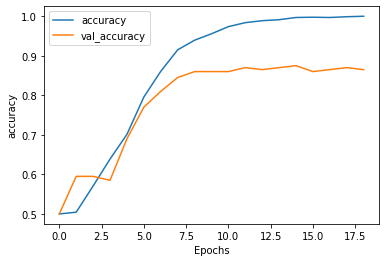

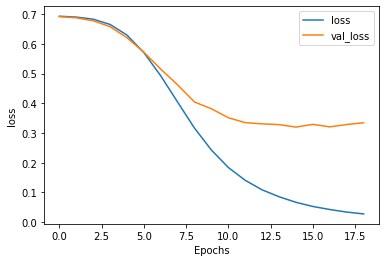

In [36]:
# taken from udacity intro to tensorflow for deep learning 
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

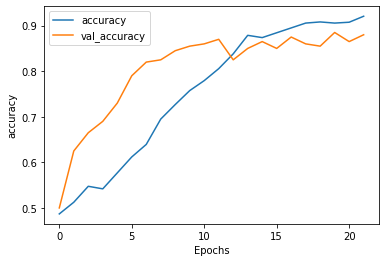

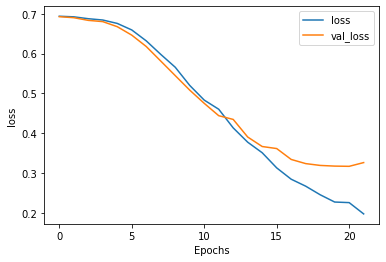

In [37]:
# display the regularized models  performance
plot_graphs(regularized_history, "accuracy")
plot_graphs(regularized_history, "loss")


In fairness both models seem to be very similar w.r.t its final performance, the only other difference i can see is that the way in which the accuracy and loss change in the first model is much more consistent and smooth and it, which makes sense, seeing as the additon of the drop-out layers would randomly remove inputs from the previous layer so the connecting layer and overal model would try to be much more robust and not be reliant on specific inputs.

Questions i have are
- The difference in performance between both models is only very small. it could also be that the min_delta i set for early stopping is a bit too high and i could have gone lower in my criteria for what is an improvement.

## **Test the model on the test set**

In [38]:
# convert the test_labels to numpy array
test_labels_np = np.array(test_labels)

print(type(test_labels_np))

<class 'numpy.ndarray'>


In [39]:
# evaluate the first model on the test set
test_history = movie_review_model.evaluate(test_features_padded_sequences,
                                           test_labels_np)


7/7 [==============================] - 0s 3ms/step - loss: 0.3247 - accuracy: 0.8844


In [40]:
# evaluate the second model on the test set
test_history_regularized = movie_review_model_regularized.evaluate(test_features_padded_sequences,
                                                                   test_labels_np)

7/7 [==============================] - 0s 3ms/step - loss: 0.3201 - accuracy: 0.8894


In [42]:
# curious about history object returned by evaluate

# returns the model loss and accuracy on the test set
print(test_history)
print(test_history_regularized)

[0.3246505856513977, 0.8844221234321594]
[0.320131778717041, 0.8894472122192383]


Again the model with the dropout set performed slightly better, but by just a small amount

In [44]:
# The history object returned by the fit function is a History callback
print(history)

help(history)

Help on History in module keras.callbacks object:

class History(Callback)
 |  Callback that records events into a `History` object.
 |  
 |  This callback is automatically applied to
 |  every Keras model. The `History` object
 |  gets returned by the `fit` method of models.
 |  
 |  Example:
 |  
 |  >>> model = tf.keras.models.Sequential([tf.keras.layers.Dense(10)])
 |  >>> model.compile(tf.keras.optimizers.SGD(), loss='mse')
 |  >>> history = model.fit(np.arange(100).reshape(5, 20), np.zeros(5),
 |  ...                     epochs=10)
 |  >>> print(history.params)
 |  {'verbose': 1, 'epochs': 10, 'steps': 1}
 |  >>> # check the keys of history object
 |  >>> print(history.history.keys())
 |  dict_keys(['loss'])
 |  
 |  Method resolution order:
 |      History
 |      Callback
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  on_epoch_end(self, epoch, logs=None)
 |      Calle

In [47]:
print(history.params)

{'verbose': 1, 'epochs': 100, 'steps': 50}


In [46]:
# history is a dictionary containing loss, val loss, accuracy and validation accuracy
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
